In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "7"

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, basic_pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import pytz

In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

args.dataset = 'ogbg-molhiv'
args.n_classes = 1
args.lr = 3e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.3
args.num_epochs = 50
args.k_hop_neighbors = 3
args.weight_decay = 1e-2
# args.bsz      = 512
args.bsz      = 448
args.strategies = ['ea', 'rw']
args.summary_node = True
args.hier_levels = 3
args.lap_k = None
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.metric = 'rocauc'
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : basic_pre_process_with_summary(d, args)
    root_path= f'dataset/{args.dataset}/basic_with_summary_{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/with_summary_k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.dataset}/{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': None, \
                 'disc': {
#                      'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                    },
                 'cont': {
                     **{('rw_' + str(k)): args.n_hid for k in range(1, args.k_hop_neighbors + 1)}
                 }
                }
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node, args.lap_k).to(args.device)

Loading data...
dataset: ogbg-molhiv 


In [4]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [5]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "mean")
n_steps   = len(dataset) // args.bsz
optimizer = get_optimizer(model, weight_decay = args.weight_decay, learning_rate = args.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.1,\
            anneal_strategy='linear', max_lr = args.lr, \
            total_steps = args.num_epochs * n_steps)

Model #Params: 10338817


In [6]:
import seaborn as sb
def mat_visualize(node_size, edge_index, edge_attr):
    mat = np.zeros((node_size, node_size))
    for e, v in zip(edge_index, edge_attr):
        mat[e[0]][e[1]] = v
    sb.heatmap(mat)

/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def turn_prob(inp):
    prob = torch.sigmoid(inp)
    prob = torch.cat([prob, 1-prob], dim=1)
    return prob

In [8]:
train_mask = torch.zeros(len(dataset), dtype=bool)
valid_mask = torch.zeros(len(dataset), dtype=bool)
test_mask = torch.zeros(len(dataset), dtype=bool)

train_mask[split_idx["train"]] = True
valid_mask[split_idx["valid"]] = True
test_mask[split_idx["test"]] = True
def entropy_loss(pred, label):
    return torch.mean(torch.sum(-label * pred, dim=1))

In [9]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    train_adv  = []
    y_true = []
    y_scores = []
    all_idx = torch.randperm(len(dataset))
    for batch_idx in tqdm(range(n_steps)):
        batch = all_idx[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        train_msk = train_mask[batch]    
        data = Batch.from_data_list(dataset[batch])
        data.to(args.device)
        
        strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
        out = model(data.x, data.batch, data.edge_index, strats)
        with torch.no_grad():
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            adv_out = model(data.x, data.batch, data.edge_index, strats)
        
        loss = criterion(out[train_msk], data.y[train_msk].float())
        adv_loss = entropy_loss(turn_prob(out).log(), turn_prob(adv_out))
        (loss + adv_loss).backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        train_adv  += [adv_loss.item()]
        
        y_true += [data.y]
        y_scores += [out]

    input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
    train_metric = evaluator.eval(input_dict)[args.metric]
    

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, data in enumerate(tqdm(valid_loader)):
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_metric = evaluator.eval(input_dict)[args.metric]
        
        test_loss = []
        y_true = []
        y_scores = []
        for data in test_loader:
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_metric = evaluator.eval(input_dict)[args.metric]

    print('Epoch %d: LR: %.5f, Train loss: %.3f Train %s: %.3f Train Adv: %.3f Valid loss: %.3f  Valid %s: %.3f \
        Test loss: %.3f  Test %s: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), args.metric, train_metric, \
             np.average(train_adv), np.average(valid_loss), args.metric, valid_metric, \
             np.average(test_loss), args.metric, test_metric))
    stats += [[epoch, np.average(train_loss), train_metric, np.average(valid_loss), valid_metric, np.average(test_loss), test_metric]]

  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1: LR: 0.00007, Train loss: 0.197 Train rocauc: 0.500 Train Adv: 0.158 Valid loss: 0.090  Valid rocauc: 0.597         Test loss: 0.145  Test rocauc: 0.608


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2: LR: 0.00013, Train loss: 0.161 Train rocauc: 0.517 Train Adv: 0.159 Valid loss: 0.098  Valid rocauc: 0.649         Test loss: 0.142  Test rocauc: 0.650


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3: LR: 0.00019, Train loss: 0.161 Train rocauc: 0.526 Train Adv: 0.156 Valid loss: 0.091  Valid rocauc: 0.694         Test loss: 0.140  Test rocauc: 0.675


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4: LR: 0.00024, Train loss: 0.157 Train rocauc: 0.604 Train Adv: 0.156 Valid loss: 0.082  Valid rocauc: 0.732         Test loss: 0.137  Test rocauc: 0.709


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5: LR: 0.00030, Train loss: 0.150 Train rocauc: 0.667 Train Adv: 0.149 Valid loss: 0.081  Valid rocauc: 0.749         Test loss: 0.144  Test rocauc: 0.713


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6: LR: 0.00029, Train loss: 0.145 Train rocauc: 0.700 Train Adv: 0.145 Valid loss: 0.085  Valid rocauc: 0.779         Test loss: 0.128  Test rocauc: 0.752


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7: LR: 0.00029, Train loss: 0.137 Train rocauc: 0.745 Train Adv: 0.141 Valid loss: 0.082  Valid rocauc: 0.769         Test loss: 0.124  Test rocauc: 0.741


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8: LR: 0.00028, Train loss: 0.135 Train rocauc: 0.745 Train Adv: 0.139 Valid loss: 0.077  Valid rocauc: 0.762         Test loss: 0.122  Test rocauc: 0.744


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9: LR: 0.00027, Train loss: 0.135 Train rocauc: 0.745 Train Adv: 0.138 Valid loss: 0.077  Valid rocauc: 0.794         Test loss: 0.128  Test rocauc: 0.750


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10: LR: 0.00027, Train loss: 0.133 Train rocauc: 0.758 Train Adv: 0.138 Valid loss: 0.075  Valid rocauc: 0.807         Test loss: 0.123  Test rocauc: 0.766


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11: LR: 0.00026, Train loss: 0.131 Train rocauc: 0.759 Train Adv: 0.135 Valid loss: 0.083  Valid rocauc: 0.783         Test loss: 0.122  Test rocauc: 0.755


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 12: LR: 0.00025, Train loss: 0.130 Train rocauc: 0.766 Train Adv: 0.135 Valid loss: 0.077  Valid rocauc: 0.766         Test loss: 0.129  Test rocauc: 0.748


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 13: LR: 0.00025, Train loss: 0.129 Train rocauc: 0.769 Train Adv: 0.135 Valid loss: 0.078  Valid rocauc: 0.775         Test loss: 0.122  Test rocauc: 0.760


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 14: LR: 0.00024, Train loss: 0.127 Train rocauc: 0.766 Train Adv: 0.134 Valid loss: 0.077  Valid rocauc: 0.788         Test loss: 0.128  Test rocauc: 0.753


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 15: LR: 0.00023, Train loss: 0.127 Train rocauc: 0.772 Train Adv: 0.134 Valid loss: 0.077  Valid rocauc: 0.768         Test loss: 0.120  Test rocauc: 0.756


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 16: LR: 0.00023, Train loss: 0.126 Train rocauc: 0.781 Train Adv: 0.134 Valid loss: 0.078  Valid rocauc: 0.748         Test loss: 0.118  Test rocauc: 0.759


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 17: LR: 0.00022, Train loss: 0.126 Train rocauc: 0.773 Train Adv: 0.133 Valid loss: 0.078  Valid rocauc: 0.766         Test loss: 0.123  Test rocauc: 0.754


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 18: LR: 0.00021, Train loss: 0.124 Train rocauc: 0.785 Train Adv: 0.129 Valid loss: 0.084  Valid rocauc: 0.777         Test loss: 0.115  Test rocauc: 0.782


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 19: LR: 0.00021, Train loss: 0.124 Train rocauc: 0.786 Train Adv: 0.133 Valid loss: 0.074  Valid rocauc: 0.761         Test loss: 0.120  Test rocauc: 0.758


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 20: LR: 0.00020, Train loss: 0.123 Train rocauc: 0.790 Train Adv: 0.130 Valid loss: 0.079  Valid rocauc: 0.753         Test loss: 0.115  Test rocauc: 0.772


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 21: LR: 0.00019, Train loss: 0.122 Train rocauc: 0.790 Train Adv: 0.130 Valid loss: 0.076  Valid rocauc: 0.737         Test loss: 0.117  Test rocauc: 0.761


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 22: LR: 0.00019, Train loss: 0.121 Train rocauc: 0.793 Train Adv: 0.129 Valid loss: 0.080  Valid rocauc: 0.781         Test loss: 0.116  Test rocauc: 0.771


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 23: LR: 0.00018, Train loss: 0.119 Train rocauc: 0.802 Train Adv: 0.130 Valid loss: 0.078  Valid rocauc: 0.793         Test loss: 0.115  Test rocauc: 0.775


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 24: LR: 0.00017, Train loss: 0.119 Train rocauc: 0.798 Train Adv: 0.132 Valid loss: 0.072  Valid rocauc: 0.782         Test loss: 0.118  Test rocauc: 0.770


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 25: LR: 0.00017, Train loss: 0.119 Train rocauc: 0.805 Train Adv: 0.129 Valid loss: 0.076  Valid rocauc: 0.735         Test loss: 0.113  Test rocauc: 0.781


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 26: LR: 0.00016, Train loss: 0.118 Train rocauc: 0.807 Train Adv: 0.127 Valid loss: 0.076  Valid rocauc: 0.729         Test loss: 0.119  Test rocauc: 0.763


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 27: LR: 0.00015, Train loss: 0.116 Train rocauc: 0.808 Train Adv: 0.126 Valid loss: 0.073  Valid rocauc: 0.782         Test loss: 0.116  Test rocauc: 0.765


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 28: LR: 0.00015, Train loss: 0.115 Train rocauc: 0.817 Train Adv: 0.124 Valid loss: 0.085  Valid rocauc: 0.794         Test loss: 0.121  Test rocauc: 0.774


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 29: LR: 0.00014, Train loss: 0.113 Train rocauc: 0.820 Train Adv: 0.127 Valid loss: 0.072  Valid rocauc: 0.782         Test loss: 0.120  Test rocauc: 0.764


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 30: LR: 0.00013, Train loss: 0.114 Train rocauc: 0.817 Train Adv: 0.123 Valid loss: 0.073  Valid rocauc: 0.795         Test loss: 0.118  Test rocauc: 0.772


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 31: LR: 0.00013, Train loss: 0.112 Train rocauc: 0.821 Train Adv: 0.120 Valid loss: 0.075  Valid rocauc: 0.775         Test loss: 0.119  Test rocauc: 0.779


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 32: LR: 0.00012, Train loss: 0.113 Train rocauc: 0.824 Train Adv: 0.123 Valid loss: 0.072  Valid rocauc: 0.799         Test loss: 0.116  Test rocauc: 0.767


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 33: LR: 0.00011, Train loss: 0.111 Train rocauc: 0.828 Train Adv: 0.121 Valid loss: 0.080  Valid rocauc: 0.792         Test loss: 0.121  Test rocauc: 0.758


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 34: LR: 0.00011, Train loss: 0.110 Train rocauc: 0.829 Train Adv: 0.124 Valid loss: 0.071  Valid rocauc: 0.793         Test loss: 0.115  Test rocauc: 0.777


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 35: LR: 0.00010, Train loss: 0.110 Train rocauc: 0.828 Train Adv: 0.118 Valid loss: 0.075  Valid rocauc: 0.809         Test loss: 0.117  Test rocauc: 0.768


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 36: LR: 0.00009, Train loss: 0.109 Train rocauc: 0.832 Train Adv: 0.119 Valid loss: 0.075  Valid rocauc: 0.812         Test loss: 0.118  Test rocauc: 0.771


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 37: LR: 0.00009, Train loss: 0.109 Train rocauc: 0.833 Train Adv: 0.120 Valid loss: 0.070  Valid rocauc: 0.814         Test loss: 0.120  Test rocauc: 0.775


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 38: LR: 0.00008, Train loss: 0.107 Train rocauc: 0.840 Train Adv: 0.116 Valid loss: 0.073  Valid rocauc: 0.800         Test loss: 0.118  Test rocauc: 0.768


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 39: LR: 0.00007, Train loss: 0.106 Train rocauc: 0.839 Train Adv: 0.118 Valid loss: 0.070  Valid rocauc: 0.802         Test loss: 0.120  Test rocauc: 0.763


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 40: LR: 0.00007, Train loss: 0.106 Train rocauc: 0.843 Train Adv: 0.116 Valid loss: 0.071  Valid rocauc: 0.810         Test loss: 0.116  Test rocauc: 0.766


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 41: LR: 0.00006, Train loss: 0.105 Train rocauc: 0.851 Train Adv: 0.118 Valid loss: 0.070  Valid rocauc: 0.794         Test loss: 0.118  Test rocauc: 0.764


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 42: LR: 0.00005, Train loss: 0.105 Train rocauc: 0.849 Train Adv: 0.116 Valid loss: 0.066  Valid rocauc: 0.823         Test loss: 0.115  Test rocauc: 0.762


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 43: LR: 0.00005, Train loss: 0.103 Train rocauc: 0.848 Train Adv: 0.115 Valid loss: 0.069  Valid rocauc: 0.814         Test loss: 0.115  Test rocauc: 0.769


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 44: LR: 0.00004, Train loss: 0.103 Train rocauc: 0.851 Train Adv: 0.117 Valid loss: 0.069  Valid rocauc: 0.807         Test loss: 0.117  Test rocauc: 0.759


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 45: LR: 0.00003, Train loss: 0.102 Train rocauc: 0.858 Train Adv: 0.112 Valid loss: 0.070  Valid rocauc: 0.815         Test loss: 0.119  Test rocauc: 0.762


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 46: LR: 0.00003, Train loss: 0.102 Train rocauc: 0.857 Train Adv: 0.114 Valid loss: 0.070  Valid rocauc: 0.815         Test loss: 0.119  Test rocauc: 0.749


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 47: LR: 0.00002, Train loss: 0.102 Train rocauc: 0.858 Train Adv: 0.113 Valid loss: 0.069  Valid rocauc: 0.814         Test loss: 0.120  Test rocauc: 0.753


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 48: LR: 0.00001, Train loss: 0.102 Train rocauc: 0.858 Train Adv: 0.112 Valid loss: 0.070  Valid rocauc: 0.819         Test loss: 0.119  Test rocauc: 0.756


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 49: LR: 0.00001, Train loss: 0.100 Train rocauc: 0.860 Train Adv: 0.113 Valid loss: 0.070  Valid rocauc: 0.817         Test loss: 0.120  Test rocauc: 0.757


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch 50: LR: -0.00000, Train loss: 0.100 Train rocauc: 0.860 Train Adv: 0.114 Valid loss: 0.070  Valid rocauc: 0.816         Test loss: 0.120  Test rocauc: 0.755


[41.          0.10493062  0.84933455  0.06622367  0.82344332  0.1153905
  0.76195176]


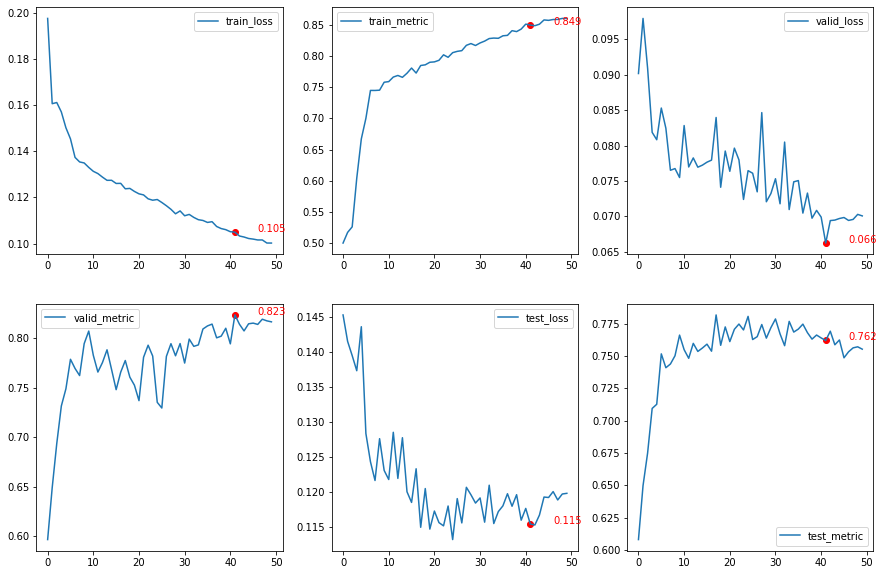

In [10]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric', 'test_loss', 'test_metric']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:, 4].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()
